Total LOS files found: 27

LOS Time Series (AOI Mean):
                                        Filename  Mean_LOS_m  \
0   LOS_20241228T234719_20250109T234718_5F34.tif   -0.007045   
1   LOS_20250109T234718_20250121T234717_F464.tif   -0.016129   
2   LOS_20250121T234717_20250202T234716_181A.tif    0.010702   
3   LOS_20250202T234716_20250214T234716_003B.tif    0.009341   
4   LOS_20250214T234716_20250226T234716_2215.tif   -0.058777   
5   LOS_20250226T234716_20250310T234716_CAD7.tif    0.027049   
6   LOS_20250310T234716_20250322T234716_4D30.tif    0.018687   
7   LOS_20250322T234716_20250403T234717_9FF7.tif    0.015665   
8   LOS_20250403T234717_20250415T234716_F1BF.tif   -0.019508   
9   LOS_20250415T234716_20250427T234717_4882.tif    0.017623   
10  LOS_20250427T234717_20250509T234716_D638.tif   -0.052247   
11  LOS_20250509T234716_20250521T234716_A545.tif   -0.085909   
12  LOS_20250521T234716_20250602T234715_9629.tif    0.130019   
13  LOS_20250708T234714_20250720T234713_A017.tif 

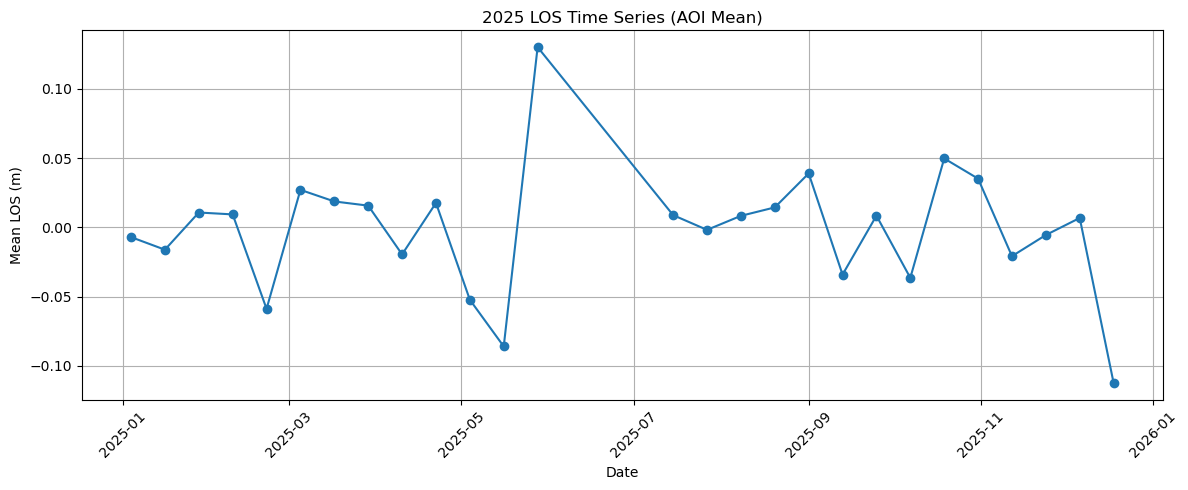

In [28]:
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

# ============================================================
# USER INPUTS
# ============================================================
los_folder = r"D:\ASF_InSAR_on_Demand\2025\Extracted\LOS_clipped"   # LOS rasters (2017)
aoi_shp = r"D:\ASF_InSAR_on_Demand\GMDA_Boundary\GMDA.shp"  # AOI shapefile

# ============================================================
# READ AOI
# ============================================================
aoi = gpd.read_file(aoi_shp)

# ============================================================
# LIST ALL LOS RASTERS
# ============================================================
files = sorted([f for f in os.listdir(los_folder) if f.endswith(".tif")])
time_series = []

print("Total LOS files found:", len(files))

# ============================================================
# LOOP THROUGH RASTERS
# ============================================================
for f in files:
    raster_path = os.path.join(los_folder, f)

    with rasterio.open(raster_path) as src:
        # Reproject AOI to raster CRS
        aoi_proj = aoi.to_crs(src.crs)
        shapes = [geom for geom in aoi_proj.geometry]

        # Clip raster to AOI
        try:
            clipped, _ = mask(src, shapes, crop=True)
        except ValueError:
            print(f"Skipping {f}: AOI does not overlap")
            continue

        data = clipped.astype(float)
        data[data == src.nodata] = np.nan

        # Skip empty rasters
        if np.all(np.isnan(data)):
            print(f"Skipping {f}: no valid LOS inside AOI")
            continue

        mean_los = np.nanmean(data)
        time_series.append((f, mean_los))

# ============================================================
# CREATE DATAFRAME
# ============================================================
df = pd.DataFrame(time_series, columns=["Filename", "Mean_LOS_m"])

# ---- Extract mid-date from filename
def extract_mid_date(fname):
    parts = fname.split("_")
    start = parts[1]
    end = parts[2]
    start_dt = datetime.strptime(start, "%Y%m%dT%H%M%S")
    end_dt = datetime.strptime(end, "%Y%m%dT%H%M%S")
    return start_dt + (end_dt - start_dt) / 2

df["Date"] = df["Filename"].apply(extract_mid_date)
df = df.sort_values("Date").reset_index(drop=True)

# ============================================================
# PRINT TABLE
# ============================================================
print("\nLOS Time Series (AOI Mean):")
print(df)

# ============================================================
# TEMPORAL PLOT ONLY
# ============================================================
plt.figure(figsize=(12,5))
plt.plot(
    df["Date"],
    df["Mean_LOS_m"],
    marker="o",
    linestyle="-"
)
plt.xlabel("Date")
plt.ylabel("Mean LOS (m)")
plt.title("2025 LOS Time Series (AOI Mean)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
